In [42]:
# from analyse_model import main as test
# test()
from tensor2tensor.visualization import attention
import h5py
import numpy as np
from sample_latent import visualize_latent_rep
from molecules.model import TriTransformer
from utils import AttnParams, load_properties, load_dataset, rdkit_funcs_mol
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
sns.set()
import os

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
model_dir = 'models/avg-mh8-KQV_medium_d96_VAE/'

# Load in model
model_params = AttnParams()
model_params.load(model_dir + "params.pkl")

# Prepare model
# Load the data
d_file = 'data/zinc_250k.h5'
d_type = 'cat' # should be onehot if conv or VAE
data_train, data_test, props_train, props_test, tokens = load_dataset(d_file, d_type, False)
props_train, props_test, prop_labels = load_properties(d_file)

model = TriTransformer(tokens, model_params)
model.build_models()
model.compile_vae(Adam(0.001, 0.9, 0.98, epsilon=1e-9))
model.autoencoder.load_weights(model_dir + "best_model.h5", by_name=True)
BNECK_ATT = True
if BNECK_ATT:
    model.output_bneck_attn.load_weights(model_dir + "best_model.h5", by_name=True)
if "FILM" in model_dir:
    model.output_film.load_weights(model_dir + "best_model.h5", by_name=True)

Returning attention
Returning bneck attn!


In [42]:
mol1 = 'CC(=O)Oc1ccccc1C(=O)O'#'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O'
mol2 = 'C[NH2+]Cc1cc2ccccc2n1C'
mol3='CC(=O)Nc1ccc(cc1Br)C#N'
mol4 = 'CC(C)(C)CC[NH2+]Cc1ccc(s1)Cl'
morphine = 'CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O'
smiles_str = mol2
molname = "mol2_FILM_o7"

if not os.path.exists(molname):
    os.mkdir(molname)
    
with open(molname+"/mol.txt","w") as f:
    f.write(smiles_str)

output_len = 6 #len(smiles_str)

smiles_seq = tokens.tokenize(smiles_str)
print(smiles_seq)
smiles_seq = [smiles_seq[0][:-1]]
output_seq = [smiles_seq[0][:output_len]]
attentions = model.output_attns.predict_on_batch([smiles_seq, output_seq])
if BNECK_ATT:
    bneck_atts = model.output_bneck_attn.predict_on_batch([smiles_seq, output_seq])

if "FILM" in model_dir:
    film = model.output_film.predict_on_batch([smiles_seq, output_seq])
    l = int(len(film)/2)
    g = film[:l]
    b = film[l:]
    

[[ 2  5 20  8 12 29 26 21  5  4 28  4  4 29  4  4  4  4  4 29  9 28  5  3]]


In [41]:
l = int(len(attentions) / 3)
h = model_params["heads"]
l_in = len(smiles_seq[0])
l_out = len(output_seq[0]) - 1

reshape_attn = lambda ATT : np.swapaxes(np.expand_dims(np.array(ATT),1), 3, 4)
reshape_attn = lambda ATT : np.expand_dims(np.array(ATT),1)
enc_atts = reshape_attn(attentions[0:l])
dec_atts = reshape_attn(attentions[l:2*l])
# dec_atts = np.expand_dims(dec_atts[:,:,:,1,:],3)

encdec_atts = reshape_attn(attentions[2 * l:])
# encdec_atts = np.expand_dims(encdec_atts[:,:,:,1,:],3)

# 	enc_atts:	  (l, 1, h, in, in)
# 	dec_atts:     (l, 1, h, 1, out)
# 	encdec_atts:  (l, 1, h, 1, in)
print("Shapes of arrays:\n\tenc_atts:\t{}\n\tdec_atts:\t{}\n\tencdec_atts:\t{}".format(np.shape(enc_atts), np.shape(dec_atts), np.shape(encdec_atts)))

print("Expected shapes of arrays:\n\tenc_atts:\t{}\n\tdec_atts:\t{}\n\tencdec_atts:\t{}".format([l, 1, h, l_in, l_in], [l, 1, h, 1, l_out], [l, 1, h, 1, l_in]))

Shapes of arrays:
	enc_atts:	(3, 1, 8, 23, 23)
	dec_atts:	(3, 1, 8, 5, 5)
	encdec_atts:	(3, 1, 8, 5, 25)
Expected shapes of arrays:
	enc_atts:	[3, 1, 8, 23, 23]
	dec_atts:	[3, 1, 8, 1, 5]
	encdec_atts:	[3, 1, 8, 1, 23]


In [ ]:
def call_html():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))


In [14]:
# Draw molecule
Draw.DrawingOptions.bondLineWidth = 1.75
Draw.MolToFile(Chem.MolFromSmiles(smiles_str), molname+'/mol.svg', size=(200, 200))

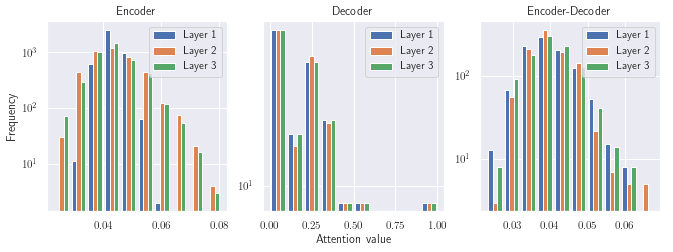

In [43]:
# HISTOGRAM OF ENCDEC ATTENTIONS
h_at = enc_atts
names = ["Encoder", "Decoder", "Encoder-Decoder"]
fig, axes = plt.subplots(1,3,figsize=(11,3.5))

for (k, h_at) in enumerate([enc_atts, dec_atts, encdec_atts]):
    nlay = np.shape(h_at)[0]
    ed = [h_at[l,:,:,:,:].flatten() for l in range(nlay)]
    labs = ["Layer {}".format(i+1) for i in range(nlay)]
    axes[k].hist(ed, log=True)
    axes[k].legend(labs)
    axes[k].set_title(names[k])
    #plt.hist(ed)
    #plt.legend(labs)

axes[0].set_ylabel("Frequency")
axes[1].set_xlabel("Attention value")
plt.savefig(molname + '/att_hists.eps', format="eps", bbox_inches="tight")
plt.show()

In [44]:
# ENCODER-ENCODER ATTENTION
escape_chars = ["&","%","$","#", "_" ,"{", "}", "~", "^", "\\"]
in_str = [tokens.token(a) for a in smiles_seq[0]]
for i in range(len(in_str)):
    in_str[i] = str(in_str[i])
    if in_str[i] in escape_chars:
        in_str[i] = "\\" + in_str[i]
    
in_str[0] = "st"
in_str[-1] = "en"
#in_str.reverse()
# plot enc-enc attn
for head in range(8):
    print("Creating diagram for head",head+1)
    n_syms = len(in_str)
    n_lays = np.shape(h_at)[0]
    t_sp = 0.5
    l_sp = 3
    a_l = 0.3
    a_r = 0.2
    m_width=2
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    while len(cols) < n_syms:
        cols.extend(cols)


    plt.figure(1, figsize=((n_lays+1)*l_sp, (n_syms+1)*t_sp))
    plt.ylim(-0.5, t_sp*n_syms + t_sp)
    plt.xlim(-0.5, l_sp*n_lays + 0.5)
    for k in range(n_lays+1):
        for (j, c) in enumerate(in_str):
            plt.text(k*l_sp, j*t_sp, c)

    for l in range(n_lays):
        plt.text((l+0.5)*l_sp, n_syms*t_sp,"\Large Layer " + str(l+1),horizontalalignment='center',)
        for i in range(n_syms):
            for j in range(n_syms):
                #print("Plotting [{},{}]->[{},{}]".format(l*l_sp+a, i*t_sp, (l+1)*l_sp-a,j*t_sp))

                plt.plot([l*l_sp+a_l, (l+1)*l_sp-a_r], [i*t_sp,j*t_sp],
                         marker=None,linestyle='-',linewidth=m_width*enc_atts[l,0,head,i,j],
                         color=cols[i])
    plt.title("\Huge Head " + str(head+1) + " encoder self attention")
    plt.axis('off')
    plt.grid(False)
    plt.savefig(molname + '/ee_head{}.png'.format(head+1), format="png", bbox_inches="tight")
    print("\tSaved head",head+1,"to",molname + '/ee_head{}.png'.format(head+1))
    plt.clf()
    #plt.show()

Creating diagram for head 1
	Saved head 1 to mol2_FILM_o7/ee_head1.png
Creating diagram for head 2
	Saved head 2 to mol2_FILM_o7/ee_head2.png
Creating diagram for head 3
	Saved head 3 to mol2_FILM_o7/ee_head3.png
Creating diagram for head 4
	Saved head 4 to mol2_FILM_o7/ee_head4.png
Creating diagram for head 5
	Saved head 5 to mol2_FILM_o7/ee_head5.png
Creating diagram for head 6
	Saved head 6 to mol2_FILM_o7/ee_head6.png
Creating diagram for head 7
	Saved head 7 to mol2_FILM_o7/ee_head7.png
Creating diagram for head 8
	Saved head 8 to mol2_FILM_o7/ee_head8.png


<Figure size 864x864 with 0 Axes>

Creating bottleneck attention diagram


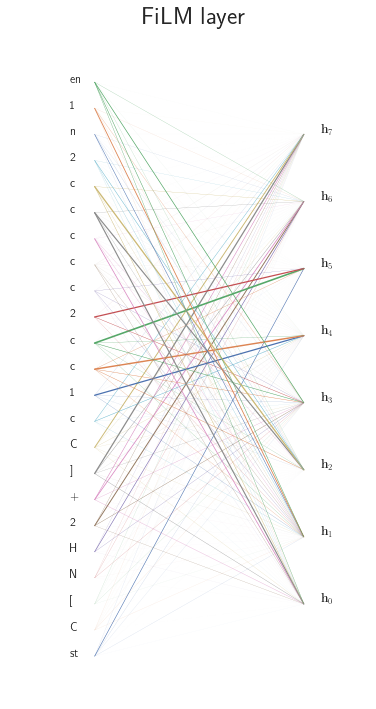

In [45]:
# BOTTLENECK ATTN
escape_chars = ["&","%","$","#", "_" ,"{", "}", "~", "^", "\\"]

in_str = [tokens.token(a) for a in smiles_seq[0]]
for i in range(len(in_str)):
    in_str[i] = str(in_str[i])
    if in_str[i] in escape_chars:
        in_str[i] = "\\" + in_str[i]
    
in_str[0] = "st"
in_str[-1] = "en"
#in_str.reverse()
# plot enc-enc attn
print("Creating bottleneck attention diagram")
n_syms = len(in_str)
n_lays = 1
n_heads = np.shape(bneck_atts)[0]
b_atts = np.squeeze(bneck_atts)
t_sp = 0.5
l_sp = 3
a_l = 0.3
a_r = 0.2
m_width=4
min_y = 1
max_y = (n_syms - 1)*t_sp - min_y
b_sp = (max_y - min_y)/(n_heads - 1)

cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
while len(cols) < n_syms:
    cols.extend(cols)


plt.figure(1, figsize=((n_lays+1)*l_sp, (n_syms+1)*t_sp))
plt.ylim(-0.5, t_sp*n_syms + t_sp)
plt.xlim(-0.5, l_sp*n_lays + 0.5)
# plot text
for (j, c) in enumerate(in_str):
    plt.text(0, j*t_sp, c)

# plot z vectors
for c in range(n_heads):
    plt.text(l_sp,min_y + c*b_sp, "$\mathbf{h}_" + str(c) + "$")

for i in range(n_syms):
    for j in range(n_heads):
        #print("Plotting [{},{}]->[{},{}]".format(l*l_sp+a, i*t_sp, (l+1)*l_sp-a,j*t_sp))
        
        plt.plot([a_l, l_sp-a_r], [i*t_sp,min_y + j*b_sp],
                 marker=None,linestyle='-',linewidth=m_width*b_atts[j,i],
                 color=cols[i])

plt.title("\Huge FiLM layer")
plt.axis('off')
plt.grid(False)
plt.savefig(molname + '/bneck_atts.png', format="png", bbox_inches="tight")
plt.show()

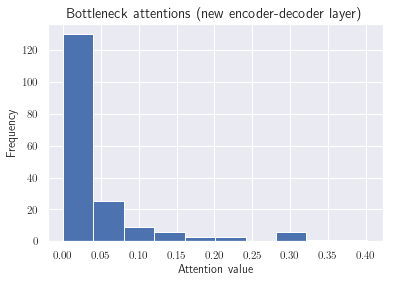

In [46]:
# HISTOGRAM OF BOTTLENECK_ATTN
h_at = np.array(bneck_atts)
h_at = h_at.flatten()
# h_at = np.squeeze(h_at)
# h_at = h_at.flatten()
plt.figure(1)
plt.hist(h_at)
plt.title("\Large Bottleneck attentions (new encoder-decoder layer)")
plt.ylabel("Frequency")
plt.xlabel("Attention value")

plt.savefig(molname + '/bneck_att_hists.eps', format="eps", bbox_inches="tight")
plt.show()

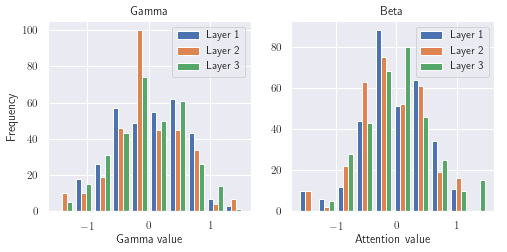

In [47]:
# Plot gammas/betas
# # HISTOGRAM OF GAMMA/BETA

names = ["Gamma","Beta"]
fig, axes = plt.subplots(1,2,figsize=(8,3.5))

for (k, v) in enumerate([g, b]):
    nlay = len(v)
    v = [m.flatten() for m in v]
    labs = ["Layer {}".format(i+1) for i in range(nlay)]
    axes[k].hist(v)
    axes[k].legend(labs)
    axes[k].set_title(names[k])
    axes[k].set_xlabel(names[k] + " value")
    #plt.hist(ed)
    #plt.legend(labs)

axes[0].set_ylabel("Frequency")
axes[1].set_xlabel("Attention value")
plt.savefig(molname + '/film_hists.eps', format="eps", bbox_inches="tight")
plt.show()

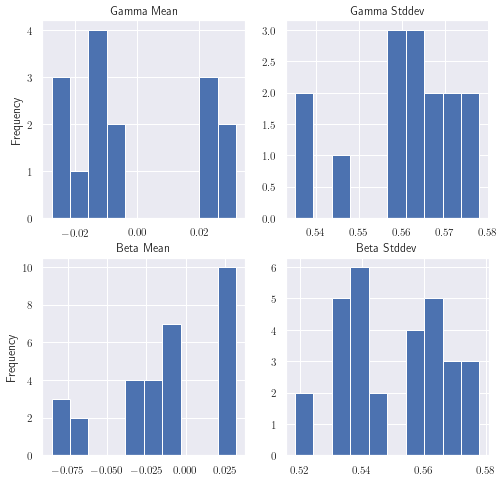

In [48]:
# Consider on a vector by vector basis
means = []
stdds = []

onames = ["Gamma", "Beta"]
names = ["Mean", "Stddev"]

fig, axes = plt.subplots(2,2,figsize=(8,8))

for (i, x) in enumerate([g, b]):
    for (layer, v) in enumerate(x):
        v = np.squeeze(v)
        means.append(np.mean(v, axis=1))
        stdds.append(np.std(v, axis = 1))

    for (k, v) in enumerate([means, stdds]):
        #nlay = len(v)
        v = np.array(v).flatten()
        #labs = ["Layer {}".format(i+1) for i in range(nlay)]
        axes[i][k].hist(v)
        axes[i][k].set_title(onames[i] + " " + names[k])
        #plt.hist(ed)
        #plt.legend(labs)

axes[0][0].set_ylabel("Frequency")
axes[1][0].set_ylabel("Frequency")
#axes[1].set_xlabel("Attention value")
plt.savefig(molname + '/film_vbv_hists.eps', format="eps", bbox_inches="tight")
plt.show()

In [96]:
mol1 = 'CC(=O)Oc1ccccc1C(=O)O'#'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O'
mol2 = 'C[NH2+]Cc1cc2ccccc2n1C'
mol3='CC(=O)Nc1ccc(cc1Br)C#N'
mol4 = 'CC(C)(C)CC[NH2+]Cc1ccc(s1)Cl'
morphine = 'CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O'
smiles_str = mol2
molname = "mol2_FILM"

if not os.path.exists(molname):
    os.mkdir(molname)
    
with open(molname+"/mol.txt","w") as f:
    f.write(smiles_str)

gs = None
for output_len in range(2,len(smiles_str)):
    smiles_seq = tokens.tokenize(smiles_str)
    smiles_seq = [smiles_seq[0][:-1]]
    output_seq = [smiles_seq[0][:output_len]]
    attentions = model.output_attns.predict_on_batch([smiles_seq, output_seq])
    if BNECK_ATT:
        bneck_atts = model.output_bneck_attn.predict_on_batch([smiles_seq, output_seq])

    if "FILM" in model_dir:
        film = model.output_film.predict_on_batch([smiles_seq, output_seq])
        l = int(len(film)/2)
        g = film[:l]
        b = film[l:]
        if gs == None:
            gs = [[] for _ in range(l)]
            bs = [[] for _ in range(l)]
        for s in range(l):
            gs[s].append(g[s])
            bs[s].append(b[s])

3
(3, 13440)
3
(3, 13440)


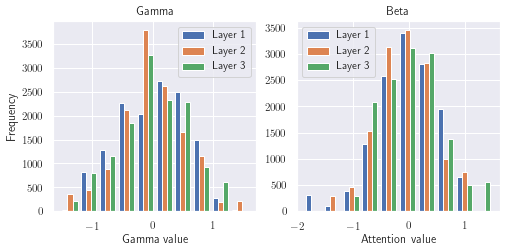

In [97]:
# Plot gammas/betas
# # HISTOGRAM OF GAMMA/BETA

names = ["Gamma","Beta"]
fig, axes = plt.subplots(1,2,figsize=(8,3.5))

for (k, v) in enumerate([gs, bs]):
    nlay = len(v)
    
    dat = []
    for s in range(nlay):
        vv = v[s]
        ss = []
        for vecs in vv:
            vecs = vecs.flatten().tolist()
            ss.extend(vecs)
        dat.append(np.array(ss).flatten())
    print(len(dat))
    print(np.shape(dat))
    #v = [np.array(s).flatten() for m in v]
    labs = ["Layer {}".format(i+1) for i in range(nlay)]
    axes[k].hist(dat)
    axes[k].legend(labs)
    axes[k].set_title(names[k])
    axes[k].set_xlabel(names[k] + " value")
    #plt.hist(ed)
    #plt.legend(labs)

axes[0].set_ylabel("Frequency")
axes[1].set_xlabel("Attention value")
plt.savefig(molname + '/film_hists_alllen.eps', format="eps", bbox_inches="tight")
plt.show()

In [43]:
# decode some random points
ldim = model.p["latent_dim"]
k = 5
z = k*np.random.randn(ldim)

print("The seed is:",z)
mols = model.decode_from_sample(z, 15)
print("The molecules are:")
#mols = [m[0] for m in mols]
num_valid = 0
rdkit_mols = []
for m in mols:
    print("\t",m[0])
    rdkit_mol = Chem.MolFromSmiles(m[0])
    if rdkit_mol: 
        print("\t\tIs valid")
        rdkit_mols.append(rdkit_mol)
        num_valid +=1
        
print("There were",num_valid,"valid mols")

The seed is: [  1.72570118  -1.22521006   0.80689888   5.86337302  -1.61980681
   2.26197603  -6.62789052   5.82306443  -0.74613765  -0.60815945
  -2.55369422   1.95475538  -4.77395     -4.05506495   1.36807773
   6.52069754  -3.30163267   6.28337571   2.10705263   2.50955928
   8.34573728  -0.41840956  -3.36212014   1.48320346   3.14992554
 -14.44243022   3.0758364    3.16680144  -0.64050801   6.31752277
  -5.96916816   8.30372685  -5.10012499  -3.11678254   1.57448516
   8.04433329  -0.08511738  -0.44896425   4.08535559  -1.9743108
  -4.91100895   2.59966328 -12.49940927  11.31661234   3.64744668
  -4.38987762   0.49008131  -7.13054547   0.19057675  11.50461392
   6.40647012  -9.39979151  -7.39304751  -4.37006504   2.95926985
  -0.77612419   7.91292914   5.14545853   8.60063637   0.5824077
  -5.56102194  -4.99787974  -2.57004648  -8.20368564   9.95892066
   3.51887008   2.18537202  -6.41945384   1.04091494   8.30241294
   2.97757271   1.42262724  -8.26237234  -1.15786677  -2.1700265


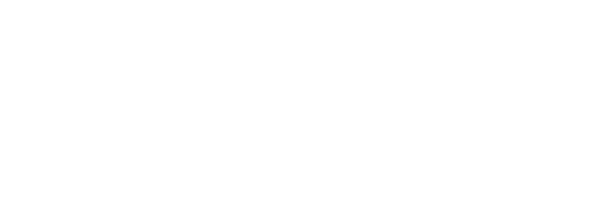

In [39]:
#show the valid mols
Draw.MolsToGridImage(rdkit_mols)